# Data Preprocessing

## Read Data

In [1]:
import pandas as pd
import talib

data_dict = {}
cols = ['open',	'high',	'low','close','volume','return']
for i in [1,2,4]:
    cols.append('ADXR'+str(i))
    cols.append('MACD'+str(i))
    cols.append('MACDsignal'+str(i))
    cols.append('MACDhist'+str(i))

for symbol in ["BTC","ETH","XRP","ADA","DOT","LTC","SHIB","MATIC", "BNB", "DOGE"]:
    df = pd.read_csv(f"./data/{symbol}USDT-1h-data.csv", index_col=0)['2021-06':]
    df.index = pd.to_datetime(df.index)
    data_dict[symbol]  = df
    for i in [1,2,4]:
        data_dict[symbol]['ADXR'+str(i)] = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=14*i)
        data_dict[symbol]['MACD'+str(i)], data_dict[symbol]['MACDsignal'+str(i)], data_dict[symbol]['MACDhist'+str(i)] = talib.MACD(df['close'], fastperiod=12*i, slowperiod=26*i, signalperiod=9*i)

    data_dict[symbol]['return'] = data_dict[symbol]['close'].shift(-1) / data_dict[symbol]['close']
data_dict

{'BTC':                          open      high       low     close       volume  \
 timestamp                                                                  
 2021-06-01 00:00:00  37253.82  37894.81  37100.00  37798.31  5234.072735   
 2021-06-01 01:00:00  37798.32  37803.49  37160.00  37196.64  3154.434156   
 2021-06-01 02:00:00  37196.64  37296.08  36620.00  36850.00  3078.850158   
 2021-06-01 03:00:00  36850.00  37124.09  36478.00  36704.99  3179.701359   
 2021-06-01 04:00:00  36706.80  36957.69  36561.89  36748.01  1767.107527   
 ...                       ...       ...       ...       ...          ...   
 2022-12-31 04:00:00  16552.46  16555.59  16541.75  16551.89  3226.938410   
 2022-12-31 05:00:00  16551.89  16566.37  16531.00  16538.76  4569.941320   
 2022-12-31 06:00:00  16538.29  16556.67  16534.03  16546.71  3921.139440   
 2022-12-31 07:00:00  16546.43  16568.12  16542.36  16565.09  4090.930410   
 2022-12-31 08:00:00  16564.81  16567.32  16552.79  16557.90  1931.47

## 計算技術指標

In [2]:
features = {}
for col in cols:
    
    # concat all df with same col
    features[col] = pd.concat([data_dict[i][col] for i in data_dict.keys()],axis=1)
    features[col].columns = data_dict.keys()
    
    # set df name to col name
    features[col].name = col

# calculate indicator features

close = features['close']
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    return (close - l) / (h - l)

indicator_features = {
    # bias
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    
    # acc
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    
    # rsv
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
}

features = {**indicator_features, **features}
features

{'bias5':                           BTC       ETH       XRP       ADA       DOT  \
 timestamp                                                               
 2021-06-01 00:00:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 2021-06-01 01:00:00  0.991977  0.987277  0.985326  0.986385  0.983525   
 2021-06-01 02:00:00  0.988422  0.987189  0.982298  0.986756  0.991522   
 2021-06-01 03:00:00  0.988354  0.986386  0.980465  0.989208  0.991273   
 2021-06-01 04:00:00  0.991592  0.990954  0.989262  0.997421  0.995591   
 ...                       ...       ...       ...       ...       ...   
 2022-12-31 04:00:00  0.999162  0.999512  0.999883  1.000163  1.000741   
 2022-12-31 05:00:00  0.998871  0.998588  0.999883  0.997876  1.000046   
 2022-12-31 06:00:00  0.999611  1.000177  1.001701  0.998121  1.000232   
 2022-12-31 07:00:00  1.000852  1.001473  1.004103  0.999918  1.004535   
 2022-12-31 08:00:00  1.000352  1.000833  1.001640  1.001145  1.003142   
 
                           

## Delete outliers & Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

# Build up features
for name, f in features.items():
    features[name] = f.unstack()

dataset = pd.DataFrame(features)
dataset = dataset.drop(columns=['open',	'high',	'low','close','volume'])

# move return to last column
dataset = dataset[[col for col in dataset if col not in ['return']] + ['return']]

# standardize (except return column remain the same)
dataset.iloc[:,:-1] = (dataset.iloc[:,:-1] - dataset.iloc[:,:-1].mean()) / dataset.iloc[:,:-1].std()

dataset.index.names = ['symbol', 'date']
dataset['rank'] = dataset.groupby('date')['return'].rank(pct=True)
feature_names = list(dataset.columns[:-2])

# drop extreme case
print("Before drop extreme case: ", dataset.shape)
dataset_drop_extreme_case = drop_extreme_case(dataset, feature_names)
print("After drop extreme case: ", dataset_drop_extreme_case.shape)

# drop nan
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

# standardize
scale = StandardScaler()
dataset_dropna.drop(columns=['symbol'], inplace=True)
stand_col = dataset_dropna.keys()[:-2]
dataset_dropna[stand_col] = scale.fit_transform(dataset_dropna[stand_col])

# save dataset
dataset_dropna.to_csv("./data/dataset.csv")

dataset_dropna

Before drop extreme case:  (138750, 23)
After drop extreme case:  (117387, 23)


,bias5,bias10,bias20,acc5,acc10,acc20,rsv5,rsv10,rsv20,ADXR1,...,ADXR2,MACD2,MACDsignal2,MACDhist2,ADXR4,MACD4,MACDsignal4,MACDhist4,return,rank
date,,,,,,,,,,,,,,,,,,,,,
2021-06-11 23:00:00,0.441357,0.537773,0.332296,-0.431144,0.573539,-0.396151,1.129628,1.310737,1.049701,-1.381772,...,-0.466979,8.681978,10.337010,-4.410275,0.639691,8.068510,5.745814,7.026434,0.992844,0.8
2021-06-12 00:00:00,-0.266264,0.036564,-0.030940,0.167952,0.290231,0.295294,-0.332022,0.259147,0.241957,-1.401472,...,-0.532582,8.383303,10.142973,-4.721971,0.583379,8.034949,5.876937,6.554142,0.977434,0.8
2021-06-12 01:00:00,-2.285930,-1.541262,-1.112249,1.264982,0.284471,0.167373,-1.241163,-1.364688,-1.437725,-1.360115,...,-0.592385,7.263233,9.849865,-7.137240,0.531400,7.704185,5.982793,5.290348,0.980686,0.2
2021-06-12 18:00:00,0.837351,0.490442,0.257713,0.963241,-2.105748,1.232548,1.232000,0.866751,-0.457974,-0.939421,...,-0.939154,-4.884947,-1.458482,-10.016971,-0.028930,1.380033,4.299031,-8.276317,0.995469,0.6
2021-06-12 19:00:00,0.272423,0.044602,0.141881,0.372223,-1.880543,1.088157,0.439765,0.073825,-0.570456,-0.896234,...,-1.000572,-4.893364,-1.827324,-8.983550,-0.056462,1.214372,4.133476,-8.284585,1.007402,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 03:00:00,-0.027524,-0.035073,0.194276,-0.189050,0.087609,-0.960450,-0.121240,-0.091967,0.937889,2.005624,...,2.694562,0.019234,0.016527,0.008510,2.178757,0.027142,0.029050,-0.004149,0.998682,0.4
2022-12-31 04:00:00,-0.117687,-0.098842,0.126359,0.020575,0.258304,-0.693453,-0.541211,-0.550147,0.768202,2.100036,...,2.665617,0.019234,0.016527,0.008511,2.217788,0.027142,0.029050,-0.004149,0.998827,0.5
2022-12-31 05:00:00,-0.197912,-0.152772,0.068413,0.004065,0.223493,-0.665154,-0.914519,-0.957418,0.617370,2.172958,...,2.644372,0.019235,0.016527,0.008511,2.258712,0.027142,0.029050,-0.004148,1.001761,0.8


## Lightgbm Model Training

In [4]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# read dataset
dataset = pd.read_csv("./data/dataset.csv", index_col=0)

# use rank as label
model = lgb.LGBMRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(dataset[feature_names].astype(float), dataset['rank'])

predict_return_val = model.predict(dataset[feature_names].astype(float))

dataset['predict_rank'] = pd.Series(predict_return_val, dataset.index)
dataset

,bias5,bias10,bias20,acc5,acc10,acc20,rsv5,rsv10,rsv20,ADXR1,...,MACD2,MACDsignal2,MACDhist2,ADXR4,MACD4,MACDsignal4,MACDhist4,return,rank,predict_rank
date,,,,,,,,,,,,,,,,,,,,,
2021-06-11 23:00:00,0.441357,0.537773,0.332296,-0.431144,0.573539,-0.396151,1.129628,1.310737,1.049701,-1.381772,...,8.681978,10.337010,-4.410275,0.639691,8.068510,5.745814,7.026434,0.992844,0.8,0.643707
2021-06-12 00:00:00,-0.266264,0.036564,-0.030940,0.167952,0.290231,0.295294,-0.332022,0.259147,0.241957,-1.401472,...,8.383303,10.142973,-4.721971,0.583379,8.034949,5.876937,6.554142,0.977434,0.8,0.586729
2021-06-12 01:00:00,-2.285930,-1.541262,-1.112249,1.264982,0.284471,0.167373,-1.241163,-1.364688,-1.437725,-1.360115,...,7.263233,9.849865,-7.137240,0.531400,7.704185,5.982793,5.290348,0.980686,0.2,0.503319
2021-06-12 18:00:00,0.837351,0.490442,0.257713,0.963241,-2.105748,1.232548,1.232000,0.866751,-0.457974,-0.939421,...,-4.884947,-1.458482,-10.016971,-0.028930,1.380033,4.299031,-8.276317,0.995469,0.6,0.531276
2021-06-12 19:00:00,0.272423,0.044602,0.141881,0.372223,-1.880543,1.088157,0.439765,0.073825,-0.570456,-0.896234,...,-4.893364,-1.827324,-8.983550,-0.056462,1.214372,4.133476,-8.284585,1.007402,0.9,0.551731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 03:00:00,-0.027524,-0.035073,0.194276,-0.189050,0.087609,-0.960450,-0.121240,-0.091967,0.937889,2.005624,...,0.019234,0.016527,0.008510,2.178757,0.027142,0.029050,-0.004149,0.998682,0.4,0.553951
2022-12-31 04:00:00,-0.117687,-0.098842,0.126359,0.020575,0.258304,-0.693453,-0.541211,-0.550147,0.768202,2.100036,...,0.019234,0.016527,0.008511,2.217788,0.027142,0.029050,-0.004149,0.998827,0.5,0.555212
2022-12-31 05:00:00,-0.197912,-0.152772,0.068413,0.004065,0.223493,-0.665154,-0.914519,-0.957418,0.617370,2.172958,...,0.019235,0.016527,0.008511,2.258712,0.027142,0.029050,-0.004148,1.001761,0.8,0.557646


## Feature Importance

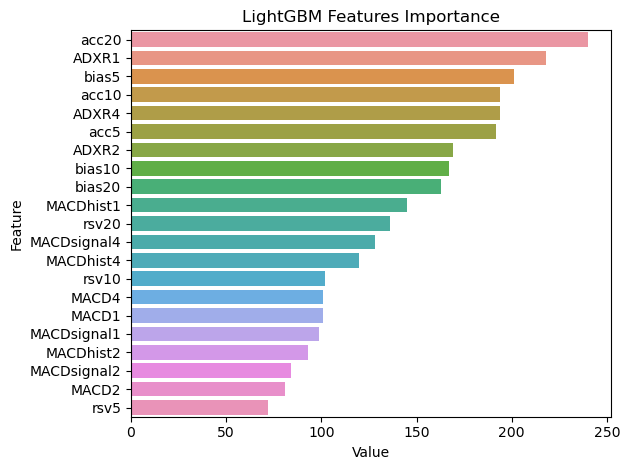

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_imp = pd.DataFrame(zip(model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)

sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('./result/lgbm_importances.png')
plt.show()

## Save Model Weight

In [6]:
# save model using joblib
import joblib
joblib.dump(model, './result/lightgbm_model.pkl')
print("Model dumped as model.pkl.")

Model dumped as model.pkl.
